#### Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from itertools import product

#Tests for sample comparison
from scipy.stats import spearmanr
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa.seasonal import seasonal_decompose

#Prophet
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation

#XGBoost
import xgboost as xgb
from xgboost import plot_importance

#Libraries for tuning NHITS and envieroment setup
import logging
from ray import tune
from IPython.display import display

#NHITS
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MAE,RMSE,MQLoss

from utilsforecast.plotting import plot_series
from utilsforecast.losses import mse, mae, rmse
from utilsforecast.evaluation import evaluate

#Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,ParameterGrid 
from sklearn.preprocessing import LabelEncoder,StandardScaler

#### Loading Data

In [ ]:
train_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/train.csv")
stores_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/stores.csv")
oil_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/oil.csv")
holiday_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/holidays_events.csv")
transactions_set =pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/transactions.csv")

#### Display Options

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
#αν θελω reset
#pd.reset_option('display.max_columns')

#### Data Preparation

In [ ]:
#ελεγχος για διπλοτυπα
print(train_set.duplicated().sum(),
      stores_set.duplicated().sum(),
      oil_set.duplicated().sum(),
      holiday_set.duplicated().sum(),
      transactions_set.duplicated().sum()
      )

In [ ]:
train_set.head()

In [ ]:
stores_set.head()

In [ ]:
oil_set.head()

In [ ]:
holiday_set.head()

In [ ]:
holiday_set.locale.unique()

In [ ]:
transactions_set.head()

In [ ]:
#Merges
df = pd.merge(train_set,stores_set,on='store_nbr',how='left')
df = pd.merge(df,oil_set,on ='date',how='left')
df = pd.merge(df,transactions_set,on=['date','store_nbr'],how='left')

In [ ]:
df.head()

In [ ]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

In [ ]:
#Κοιταω για Nas
df.isna().sum()

In [ ]:
sales_zero = df[df['sales'] == 0]

In [ ]:
sales_zero.isna().sum() # 291028 - 245869 = 45159

In [ ]:
df.loc[df['sales']==0,'transactions']=0
del sales_zero
df['transactions'] = df.groupby('store_nbr')['transactions'].ffill()

In [ ]:
#Απο αυτο βλεπουμε οτι δεν εχουμε την τιμη του πετρελαιου για ολες τις ημερομινιες
print(len(train_set['date'].unique()),len(oil_set['date'].unique()))

In [ ]:
df['date']= pd.to_datetime(df['date'])
df['day']= df['date'].dt.day_name()
working_days = df[df['date'].dt.dayofweek < 5]

In [ ]:
print(df.loc[df['day'] == 'Saturday', 'dcoilwtico'].isna().sum() +
      df.loc[df['day'] == 'Sunday', 'dcoilwtico'].isna().sum() 
      )

In [ ]:
#Βρισκω το Σ/Κ με τιμες Na στο πετρελαιο
weekend_mask = df['day'].isin(['Saturday', 'Sunday']) & df['dcoilwtico'].isna()
df['price_filled'] = df['dcoilwtico']
df['price_filled'] = df['price_filled'].where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
df['price_filled'] = df['price_filled'].ffill()
df.loc[weekend_mask, 'dcoilwtico'] = df.loc[weekend_mask, 'price_filled']
df.drop(columns=['price_filled'], inplace=True)

In [ ]:
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].bfill()
df['transactions'] = df['transactions'].fillna(0)

In [ ]:
#Για τις υπολοιπες τιμες του πετρελαιου που δεν εχουμε κανουμε imputation
#df['dcoilwtico'] = df['dcoilwtico'].ffill()

In [ ]:
holiday_set.isna().sum()

In [ ]:
df.info()

In [ ]:
transactions_set.isna().sum()

In [ ]:
df.isna().sum()

In [ ]:
df.isna().sum()

In [ ]:
df.head()

#### Exploratory Data Analysis

In [ ]:
df.head()

In [ ]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

In [ ]:
len(df['store_nbr'].unique())

In [ ]:
df['family'].unique()

In [ ]:
len(df['family'].unique())

In [ ]:
df['city'].unique()

In [ ]:
len(df['city'].unique())

In [ ]:
df['state'].unique()

In [ ]:
len(df['state'].unique())

In [ ]:
df['type'].unique()

In [ ]:
df['cluster'].unique()

In [ ]:
df['day'].unique()

In [ ]:
df[['sales','onpromotion','transactions','dcoilwtico']].describe()

In [ ]:
#Εδω δημιουργω ενα γραφημα για τα sales σε βαθος χρονου
#Για να γινει αυτο θα πρεπει να αθροισω τα sales καθε μερας καθως το υπαρχον dataset εχει 
#sales για ολες τις ημερες 
daily_sales = df[['date','sales']].copy()
daily_sales = daily_sales.groupby('date').sum().reset_index()


In [ ]:
px.line(daily_sales,x='date',y='sales',title="Daily Sales")

In [ ]:
#Εδω ενονω τις τιμες του πετρελαιου με τα daily sales για να κανω correlation test
daily_oil = df[['date', 'dcoilwtico']].dropna().drop_duplicates(subset='date')
daily_df = pd.merge(daily_sales,daily_oil,on='date',how='left')
daily_df.head()

In [ ]:
moving_average = daily_df['sales'].rolling(
    window = len(daily_df['sales']),
    center = True,
    min_periods = len(daily_df['sales'])//2,
).mean()

daily_df['moving_average'] = moving_average

In [ ]:
fig1 = px.scatter(daily_df, x='date', y='sales')
fig2 = px.line(daily_df, x='date', y='moving_average', color_discrete_sequence=['red'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3 = fig3.update_layout(xaxis_title="Sales", yaxis_title="Date", title = 'Moving Average Over Time')
fig3.show()

In [ ]:
df['year'] = df['date'].dt.year
avg_sales_year_family = df.groupby(['year', 'family'])['sales'].mean().reset_index()

In [ ]:

fig = px.line(
    avg_sales_year_family,
    x='year',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap= 4,
    markers=True,
    title='Average Yearly Sales per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Year',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [ ]:
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')
avg_sales_by_month = df.groupby(['month', 'month_name', 'family'])['sales'].mean().reset_index()

avg_sales_by_month = avg_sales_by_month.sort_values('month')

In [ ]:
fig = px.line(
    avg_sales_by_month,
    x='month_name',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_spacing=0.1,
    facet_col_wrap=4,
    markers=True,
    category_orders={"month_name": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]},
    title='Average Sales by Calendar Month per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Month',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [ ]:
df['day_nbr'] = df['date'].dt.weekday
avg_sales_by_weekday = df.groupby(['day_nbr', 'day', 'family'])['sales'].mean().reset_index()

In [ ]:
avg_sales_by_weekday = avg_sales_by_weekday.sort_values('day_nbr')
fig = px.line(
    avg_sales_by_weekday,
    x='day',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap=4,
    markers=True,
    category_orders={"day": [
        "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    ]},
    title='Average Sales by Day of Week per Product Family'
)

fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Day of Week',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [ ]:
t = df.groupby("family")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='family',x='sales',color='family',title='Average sales per product family')

In [ ]:
t = df.groupby("city")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='city',x='sales',color='city',title='Average sales per City')

In [ ]:

temp = df[["store_nbr", "sales"]].copy()
temp["ind"] = 1
temp["ind"] = temp.groupby("store_nbr")["ind"].cumsum().values
pivot_sales = pd.pivot(temp, index="ind", columns="store_nbr", values="sales")

corr_matrix = pivot_sales.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among stores", fontsize=20)
plt.show()

#### Oil Price - Impact on Sales

In [ ]:
#Αυτο εχει και αλλη δουλεια
px.line(daily_oil,x='date',y='dcoilwtico')

In [ ]:
plt.hist(daily_df['sales'],bins=30, color='skyblue', edgecolor='black');

In [ ]:
plt.hist(daily_df['dcoilwtico'],bins=30, color='skyblue', edgecolor='black');

In [ ]:
corr, p_value = spearmanr(daily_df['sales'], daily_df['dcoilwtico'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(daily_df['dcoilwtico'], daily_df['sales'], alpha=0.5)
plt.title('Sales ~ Dcoilwtico')
plt.xlabel('dcoilwtico')
plt.ylabel('sales')
plt.grid(True)
plt.show()


#### OnPromotion - Impact on Sales

In [ ]:
corr, p_value = spearmanr(df['sales'], df['onpromotion'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['onpromotion'],df['sales'], alpha=0.5)
plt.title('Sales ~ Onpromotion')
plt.xlabel('Onpromotion')
plt.ylabel('sales')
plt.grid(True)
plt.show()

#### Earthquake - Impact on Sales

In [ ]:
daily_df["date"] = pd.to_datetime(daily_df["date"])
before = daily_df[(daily_df["date"] >= '2016-03-01') & (daily_df["date"] <= '2016-04-15')]
after = daily_df[(daily_df["date"] >= '2016-04-16') & (daily_df["date"] <= '2016-05-31')]

In [ ]:
plt.hist(before['sales'], bins=30, color='skyblue', edgecolor='black');


In [ ]:
plt.hist(after['sales'], bins=30, color='skyblue', edgecolor='black');


In [ ]:
stat, p_value = mannwhitneyu(before['sales'], after['sales'])

print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

In [ ]:
before[['sales']].describe()

In [ ]:
after[['sales']].describe()

In [ ]:
df[['sales']].describe()

In [ ]:
del avg_sales_by_month,avg_sales_by_weekday,avg_sales_year_family,moving_average,daily_df,daily_oil,daily_sales
del train_set,oil_set,transactions_set,stores_set,before,after,weekend_mask
del fig,fig1,fig2,fig3,working_days,

In [ ]:
%who

In [ ]:
holiday_set['date'] = pd.to_datetime(holiday_set['date'])
holiday_set[holiday_set['transferred']==True]

In [ ]:
#Το προβλημα με τα transfers
temp1 = holiday_set[(holiday_set['type']=='Holiday')& (holiday_set['transferred']==True)].drop('transferred',axis=1).reset_index(drop=True)
temp2 = holiday_set[(holiday_set['type']=='Transfer')].drop('transferred',axis=1).reset_index(drop=True)
temp = pd.concat([temp1,temp2],axis=1)
temp = temp.iloc[:,[5,1,2,3,4,]]
holiday_set = holiday_set[(holiday_set['type']!='Transfer')& (holiday_set['transferred']==False)].drop('transferred',axis=1)
holiday_set = pd.concat([holiday_set, temp]).reset_index(drop=True)
del temp,temp1,temp2

In [ ]:
holiday_set['type']= np.where(holiday_set['type']=='Additional','Holiday',holiday_set['type'])
holiday_set['type']= np.where(holiday_set['type']=='Bridge','Holiday',holiday_set['type'])

In [ ]:
work_days_left = holiday_set[holiday_set.type=='Work Day']
holiday_set = holiday_set[holiday_set.type!='Work Day']

In [ ]:
#Κραταω αυτο για το Prophet μετα
holidays_for_prophet = holiday_set.drop(['type','locale','locale_name'],axis=1)

In [ ]:
events = holiday_set[holiday_set.type=='Event'].drop(['type','locale','locale_name'],axis=1)
events= events.rename({"description":"event"},axis=1)
holiday_set = holiday_set[holiday_set.type!='Event'].drop("type",axis=1)

In [ ]:
regional = holiday_set[holiday_set['locale']=='Regional'].rename({"locale_name":"state","description":"holiday_regional"},axis=1).drop("locale",axis=1).drop_duplicates()
national = holiday_set[holiday_set['locale']=='National'].rename({"description":"holiday_national"},axis=1).drop(["locale","locale_name"],axis=1).drop_duplicates()
local = holiday_set[holiday_set['locale']=='Local'].rename({"locale_name":"city","description":"holiday_local"},axis=1).drop("locale",axis=1).drop_duplicates()

In [ ]:
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])
df = pd.merge(df,national,how='left',on='date')
df = pd.merge(df,regional,how='left',on=['date',"state"])
df = pd.merge(df,local,how='left',on=['date',"city"])
df = pd.merge(df,events,on=['date'],how='left')
del national,regional,local

In [ ]:
df["holiday_national_binary"] = np.where(df["holiday_national"].notnull(),1,0)
df["holiday_regional_binary"] = np.where(df["holiday_regional"].notnull(),1,0)
df["holiday_local_binary"] = np.where(df["holiday_local"].notnull(),1,0)

In [ ]:
encoded_events= pd.get_dummies(events,"event",dtype=int)
encoded_events.columns=encoded_events.columns.str.replace(" ","_")
encoded_events.columns=encoded_events.columns.str.replace(":","_")
encoded_events.columns=encoded_events.columns.str.replace("+","_")
encoded_events.columns=encoded_events.columns.str.replace("-","_")
df = pd.merge(df,encoded_events,how='left',on='date')
del encoded_events,events

In [ ]:
df['event'] = df['event'].fillna('no_event')
df['holiday_national'] = df['holiday_national'].fillna('no_holiday')
df['holiday_regional'] = df['holiday_regional'].fillna('no_holiday')
df['holiday_local'] = df['holiday_local'].fillna('no_holiday')
event_cols = [col for col in df.columns if col.startswith('event')]
event_cols.remove('event')
df[event_cols] = df[event_cols].fillna(0).astype(int)

In [ ]:
def AB_Test(d,group,target):
    groupA = d[d[group] == 1][target]
    groupB = d[d[group] == 0][target]
    if(len(groupA)<50):
        t1 = shapiro(groupA)[1] < 0.05
    else:
        t1 = lilliefors(groupA)[1] < 0.05
    
    if(len(groupB)<50):
        t2 = shapiro(groupB)[1] < 0.05
    else:
        t2 = lilliefors(groupB)[1] < 0.05
    
    if (t1 == False) & (t1 == False):
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
        if leveneTest == False:
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]

        else:
            ttest = stats.wilcoxon(groupA, groupB, equal_var=False)[1]

    else:
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 

    temp = pd.DataFrame({
        "variable":[group],
        "p-value":[ttest]
    })
    return temp

results = []

for i in ['holiday_national_binary','holiday_regional_binary','holiday_local_binary']:
    results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))

results = pd.concat(results)

In [ ]:
results

In [ ]:
# results=[]
# for i in event_cols:
#     results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))
# results = pd.concat(results)
# results

In [ ]:
results.loc[results['p-value']>0.05,]
del results

In [ ]:
df['unique_id'] = df['store_nbr'].astype(str) + '_' + df['family']

In [ ]:
#Zero forecasting
zero_sales = df[['unique_id','sales']].copy()
zero_sales=zero_sales.groupby(['unique_id']).sum().reset_index()
zero_sales=zero_sales[zero_sales['sales']==0]

In [ ]:
zero_sales

In [ ]:
zero_sales.shape # βαση αυτου υπαρχουν 53 combos που εχουν 0 πωλησεις

In [ ]:
# zero_sales_by_day = df[df['sales'] == 0].groupby('day').size()
# total_by_day = df.groupby('day').size()
# zero_sales_rate = zero_sales_by_day / total_by_day

In [ ]:
# zero_sales_by_day.plot(kind='bar', title='Number of Zero Sales by Day of Week')
# plt.xlabel('Day of Week')
# plt.ylabel('Number of Zero Sales')
# plt.show()

In [ ]:
# avg_sales_per_uid = df.groupby('unique_id')['sales'].mean().reset_index()
# avg_sales_per_uid.columns = ['unique_id', 'avg_sales']
# avg_sales_per_uid.sort_values(by='avg_sales', ascending=False, inplace=True)

#### Models

In [ ]:
#Prophet

In [ ]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

In [ ]:
dicts = {}

for feature in total_sales_df.columns[:1]:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,}

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    rmses = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days")
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        rmses.append(df_p["rmse"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["rmse"] = rmses
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

In [ ]:
prediction_days = 30
forecast_start_date = '2017-07-15'

In [ ]:
holidays_for_prophet=holidays_for_prophet.rename({'date':'ds','description':'holiday'},axis=1)
holidays_for_prophet['ds'] = pd.to_datetime(holidays_for_prophet['ds'])

In [ ]:
for feature in total_sales_df.columns[:1]:

    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this unique_id
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holidays_for_prophet
                )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,np.sqrt(mean_squared_log_error(predicted_df['y'],predicted_df['yhat'])))

In [ ]:
forecast_start_date= max(total_sales_df.index)

In [ ]:
forecast_start_date

In [ ]:
forecasted_dfs = []

for feature in total_sales_df.columns[:1]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holidays_for_prophet
                )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    #forecasted_dfs.append(forecasted_df) #οταν αλλαξω το ποσα combos θα δω τοτε θα βαλω αυτο

In [ ]:
#END OF PROPHET

In [ ]:
original = df.copy()

In [ ]:
#LightGBM

In [ ]:
import warnings
warnings.filterwarnings("once")

In [ ]:
df= df.drop(event_cols,axis=1)

In [ ]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'year',
 'month',
 'holiday_national_binary',
 'oil_lag_1',
 'lag_7',
 'lag_14',
 'lag_28',
 'rolling_mean_7',
 'rolling_mean_14',
 'rolling_std_7',
 'oil_lag_7',
 'oil_lag_14',
 # 'unique_id',
 #'family',                                  # αυτα ειναι ολα τα features που τεσταρα αλλα τελικα δεν κρατησα
 #'is_weekend',
 #'store_nbr',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 #'holiday_local_binary',
 #'holiday_regional_binary',
 #'lag_1',
 #'trans_lag_1',                                    # Αυτα ηταν lags για τα transactions
 #'trans_lag_7',
 #'trans_lag_14'
]

In [ ]:
#Tuning
dicts = {}
i = 0
for feature in total_sales_df.columns[:2]:
    selected_feature = str(feature)
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == selected_feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df['sales']
    X = category_df[features].copy()

    param_grid = {
        'max_depth':[7],
        'num_leaves': [15, 31,64],
        'learning_rate': [0.01,0.05, 0.1],
        'n_estimators': [1000],
        'reg_alpha': [0.0, 0.1],
        'reg_lambda': [0.0, 0.1],
        'min_child_samples': [20, 50]
    }

    lgb_reg = lgb.LGBMRegressor()

    tscv = TimeSeriesSplit(n_splits=6, test_size=30)
    grid = GridSearchCV(estimator=lgb_reg,
                        param_grid=param_grid,
                        cv=tscv,
                        scoring='neg_root_mean_squared_error',
                        verbose=0)
    grid.fit(X, y)

    best_params = grid.best_params_
    best_score = -grid.best_score_

    best_params_with_score = best_params.copy()
    best_params_with_score["rmse"] = best_score
    dicts[feature] = best_params_with_score
    print(f"✅-{i}")
    i += 1

In [ ]:
results = []
i = 0
for feature in total_sales_df.columns[:2]:
    selected_feature = str(feature)
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == selected_feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]

    test_start='2017-07-15'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()

    y_train = y_train.drop(['date'],axis=1)
    y_val = y_val.drop(['date'],axis=1)

    X_train = X_train[features]
    X_val = X_val[features]

    model = LGBMRegressor(
        max_depth=dicts[feature]['max_depth'],
        num_leaves=dicts[feature]['num_leaves'],
        learning_rate=dicts[feature]['learning_rate'],
        n_estimators=dicts[feature]['n_estimators'],
        reg_alpha=dicts[feature]['reg_alpha'],
        reg_lambda=dicts[feature]['reg_lambda'],
        min_child_samples=dicts[feature]['min_child_samples'],
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ])

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))

    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[selected_feature],
                "rmse":[rmse],
                "ymean": [m],
                "rmsle":[rmsle],
                })
    results.append(temp1)
    print(f"✅-{i}")
    i += 1
results=pd.concat(results)

In [167]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'year',
 'month',
 'holiday_national_binary',
 'oil_lag_1',
 'lag_7',
 'lag_14',
 'lag_28',
 'rolling_mean_7',
 'rolling_mean_14',
 'rolling_std_7',
 'oil_lag_7',
 'oil_lag_14',
 'unique_id',
]
X = df[features].copy()

In [206]:
test_start='2017-07-15'
X_train = df[df['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df[df['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()
dates_val = y_val['date']

y_train = y_train['sales']
y_val = y_val['sales']

X_train = X_train[features]
X_val = X_val[features]

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

cat_cols = ['unique_id']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    num_leaves=127,
    max_depth=10,
    learning_rate=0.05,
    n_estimators=1000,
    random_state=1
)

model.fit(
    X_train, y_train_log,
    eval_set=[(X_val, y_val_log)],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_pred = np.maximum(0, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
rmsle
#model = LGBMRegressor(
#     objective='regression',
#     metric='rmse',                   
#     boosting_type='gbdt',            
#     num_leaves=64,                   
#     max_depth=7,                     
#     learning_rate=0.05,              
#     n_estimators=1000,               
#     random_state=1
# )
# model.fit(
#     X_train, y_train,
#     eval_set=[(X_val, y_val)],
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
# )

# y_pred = model.predict(X_val)
# y_pred = np.maximum(0, y_pred)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
# rmsle

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4285
[LightGBM] [Info] Number of data points in the train set: 2901360, number of used features: 15
[LightGBM] [Info] Start training from score 2.929669
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.151886
[200]	valid_0's l2: 0.150191
Early stopping, best iteration is:
[184]	valid_0's l2: 0.149845


np.float64(0.38709761158990125)

In [197]:
r2_score(y_val, np.maximum(0, y_pred))

0.9667138813866356

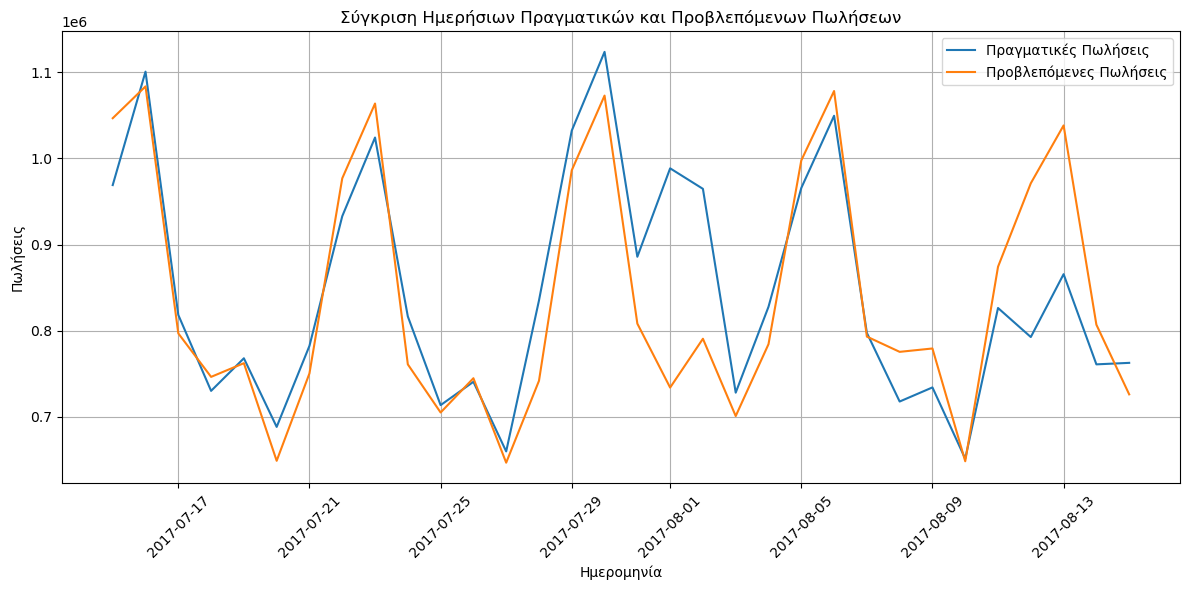

In [198]:
df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val,
    'predicted': y_pred
})

daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Πραγματικές Πωλήσεις')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Προβλεπόμενες Πωλήσεις')
plt.xlabel('Ημερομηνία')
plt.ylabel('Πωλήσεις')
plt.title('Σύγκριση Ημερήσιων Πραγματικών και Προβλεπόμενων Πωλήσεων')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

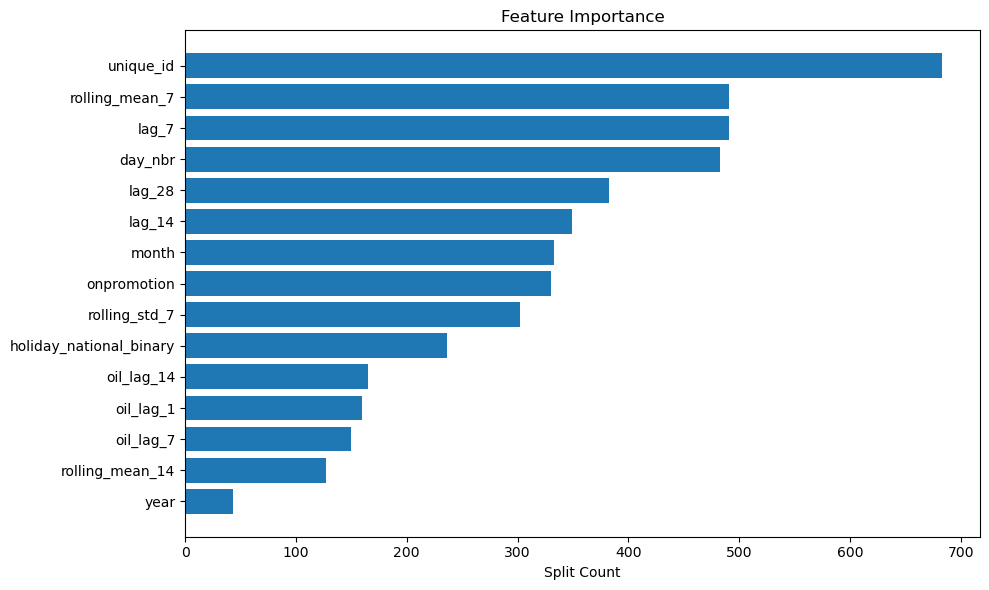

In [171]:
# Feature importance (split count)
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True)

# Horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Split Count')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
#XGBoost

In [ ]:
df = original.copy()

In [ ]:
df = df[~df['unique_id'].isin(zero_sales['unique_id'])]
df= df.drop(event_cols,axis=1)

In [ ]:
#df['lag_1'] = df.groupby(['store_nbr','family'])['sales'].shift(1)
df['lag_7'] = df.groupby(['store_nbr','family'])['sales'].shift(7)
df['lag_14'] = df.groupby(['store_nbr','family'])['sales'].shift(14)
df['lag_28'] = df.groupby(['store_nbr','family'])['sales'].shift(28)
df['rolling_mean_7'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
df['rolling_mean_14'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(14).mean())
df['rolling_std_7'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(7).std())
df['oil_lag_1'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(1)
df['oil_lag_7'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(7)
df['oil_lag_14'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(14)
df= df.dropna()

In [199]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'year',
 'month',
 'holiday_national_binary',
 'unique_id',
 'oil_lag_1',
 'lag_7',
 'lag_14',
 'lag_28',
 'rolling_mean_7',
 'rolling_mean_14',
 'rolling_std_7',
 'oil_lag_7',
 'oil_lag_14',
 #'family',                                  # αυτα ειναι ολα τα features που τεσταρα αλλα τελικα δεν κρατησα
 #'is_weekend',
 #'store_nbr',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 #'holiday_local_binary',
 #'holiday_regional_binary',
 #'lag_1',
 #'trans_lag_1',                                    # Αυτα ηταν lags για τα transactions
 #'trans_lag_7',
 #'trans_lag_14'
]
X = df[features].copy()


In [200]:
test_start='2017-07-15'
X_train = df[df['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df[df['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()
dates_val = y_val['date']

# y_train = y_train.drop(['date'],axis=1)
# y_val = y_val.drop(['date'],axis=1)

y_train = y_train['sales']
y_val = y_val['sales']


X_train = X_train[features]
X_val = X_val[features]

# clip_threshold = y_train['sales'].quantile(0.995)
# y_train['sales'] = y_train['sales'].clip(upper=clip_threshold)
# y_val['sales'] = y_val['sales'].clip(upper=clip_threshold)

cat_cols = ['unique_id']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                        enable_categorical=True,  
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=7,
                        learning_rate=0.05,
                        random_state=1
                        )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

y_pred = reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val,
    'predicted': y_pred
})

[0]	validation_0-rmse:1106.90338	validation_1-rmse:1304.93029


/home/armandoim/miniconda3/envs/myenv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning:

[23:49:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1745056857893/work/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:218.90267	validation_1-rmse:234.58127
[125]	validation_0-rmse:209.24243	validation_1-rmse:235.07743


In [201]:
y_val_clipped = np.maximum(y_val, 0)
y_pred_clipped = np.maximum(y_pred, 0)

r2 = r2_score(y_val_clipped, y_pred_clipped)
rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, y_pred_clipped))
rmse = np.sqrt(mean_squared_error(y_val_clipped, y_pred_clipped))
print(r2,rmsle,rmse)

0.9675741341487979 0.4753172149941563 231.98702722691223


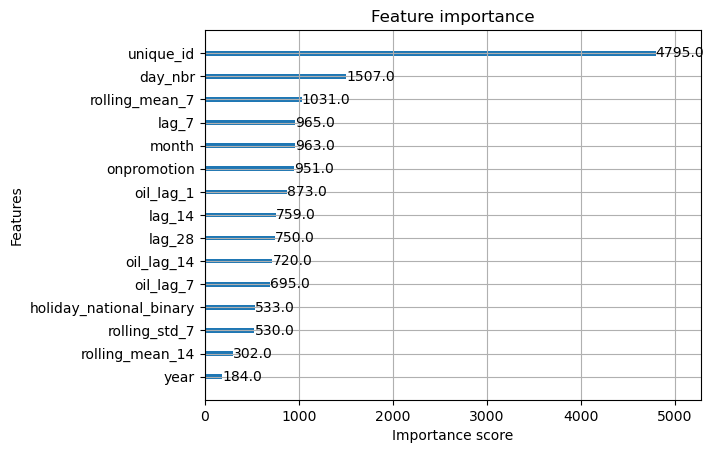

In [202]:
plot_importance(reg, max_num_features=20)
plt.show()

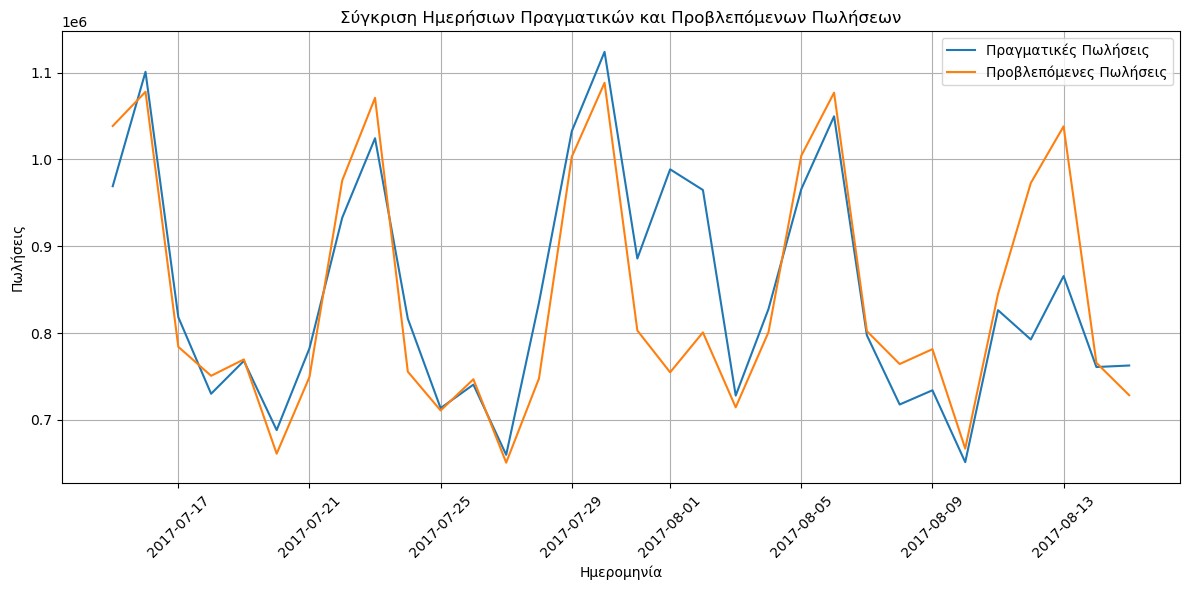

In [204]:
df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val_clipped,
    'predicted': y_pred_clipped
})

daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Πραγματικές Πωλήσεις')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Προβλεπόμενες Πωλήσεις')
plt.xlabel('Ημερομηνία')
plt.ylabel('Πωλήσεις')
plt.title('Σύγκριση Ημερήσιων Πραγματικών και Προβλεπόμενων Πωλήσεων')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#XGBoost Loop

In [ ]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
total_sales_df.columns.tolist().index('45_BEVERAGES')

In [ ]:
avg_sales_per_uid = df.groupby('unique_id')['sales'].mean().reset_index()
avg_sales_per_uid.columns = ['unique_id', 'avg_sales']
avg_sales_per_uid.sort_values(by='avg_sales', ascending=False, inplace=True)

In [ ]:
avg_sales_per_uid.sort_values(by='avg_sales', ascending=False, inplace=True)


In [ ]:
avg_sales_per_uid.head(10)

In [ ]:
results = []
i = 0
for feature in total_sales_df.columns[1216:1217]:
    selected_feature = str(feature)
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == selected_feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]

    test_start='2017-07-15'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()

    y_train = y_train.drop(['date'],axis=1)
    y_val = y_val.drop(['date'],axis=1)

    X_train = X_train[features]
    X_val = X_val[features]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                            enable_categorical=True,  
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=7,
                            learning_rate=0.05,
                            random_state=1
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))

    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[selected_feature],
                "rmse":[rmse],
                "ymean": [m],
                "rmsle":[rmsle],
                })
    results.append(temp1)
    print(f"✅-{i}")
    i += 1
results=pd.concat(results)

In [ ]:
results

In [ ]:
high_rmsle_count = (results["rmsle"] > 0.5).sum()
print("RMSLE > 0.5:", high_rmsle_count)


In [ ]:
tscv = TimeSeriesSplit(n_splits=6, test_size=30)

In [ ]:
df_plot = pd.DataFrame({
    'date': dates_val.unique(),
    'actual': y_val['sales'].values,
    'predicted': y_pred
})

daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Πραγματικές Πωλήσεις')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Προβλεπόμενες Πωλήσεις')
plt.xlabel('Ημερομηνία')
plt.ylabel('Πωλήσεις')
plt.title('Σύγκριση Ημερήσιων Πραγματικών και Προβλεπόμενων Πωλήσεων')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# base_score=0.5, booster='gbtree', 
#                         enable_categorical=True,  
#                         n_estimators=1000,
#                         early_stopping_rounds=50,
#                         objective='reg:linear',
#                         max_depth=7,
#                         learning_rate=0.05,
#Αυτα ειχαν 201 RMSE

param_grid = {
    'max_depth': [7],
    'learning_rate': [0.05,0.1],
    'n_estimators': [1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1],
}

In [ ]:
for params in ParameterGrid(param_grid):
    model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        enable_categorical=True,
        objective='reg:linear',
        early_stopping_rounds=50,
        **params
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=0
    )

    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, preds))
    print(f"Params: {params} --> RMSE: {score:.4f}")


In [ ]:
df[df['date']=='2017-07-31']

In [ ]:
#NHITS

# Θελω για αρχη να τρεξω το μοντελο μονο με τις static μεταβλητες
df = df.drop([ 'id','onpromotion', 'city','state', 'type', 'cluster', 'dcoilwtico', 'transactions', 'day','holiday_national', 'holiday_regional', 'holiday_local', 'event',
       'holiday_national_binary', 'holiday_regional_binary',
       'holiday_local_binary',],axis=1)
df['unique_id'] = df['store_nbr'].astype(str) + '_' + df['family']
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['sales']

In [ ]:
logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

In [ ]:
duplicates = df.groupby(['unique_id', 'ds']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

if duplicates.empty:
    print("✅ Κάθε unique_id εμφανίζεται το πολύ μία φορά ανά ημερομηνία.")
else:
    print("❌ Υπάρχουν διπλότυπα:")
    display(duplicates.head())

df_agg = df.groupby(['unique_id', 'ds'], as_index=False)['y'].sum()
df = df_agg

# Split into train and future (NHITS uses sliding windows, not test sets in the usual sense)
df_train = df.groupby('unique_id').apply(lambda x: x.iloc[:-30]).reset_index(drop=True)
df_test = df.groupby('unique_id').apply(lambda x: x.iloc[-30:]).reset_index(drop=True)


model = NeuralForecast(
    models=[NHITS(input_size=90, h=30, max_steps=2000, scaler_type='standard', loss=RMSE(),learning_rate=5e-5)],
    freq='D',
)

# model = NeuralForecast(models=[NHITS(input_size=2*H, h=H)], freq='D')
# Fit the model
model.fit(df_train)

In [ ]:
# Predict
df_forecast = model.predict()

# Rename 'y' to 'y_actual' in df_test to match expected column name after merge
df_test_renamed = df_test.rename(columns={'y': 'y_actual'})

In [ ]:
# Merge forecasts and actuals
df_eval = pd.merge(
    df_forecast, 
    df_test_renamed, 
    on=['unique_id', 'ds'], 
    how='left'
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_squared_log_error
import numpy as np
# Calculate metrics
mae = mean_absolute_error(df_eval['y_actual'], df_eval['NHITS'])
rmse = np.sqrt(mean_squared_error(df_eval['y_actual'], df_eval['NHITS']))
#rmsle = np.sqrt(mean_squared_log_error(df_eval['y_actual'], df_eval['NHITS']))
print(f"MAE:  {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
#print(f"RMSLE:  {rmsle:.2f}")

In [ ]:
df_forecast= df_forecast.reset_index()

In [ ]:
plot_series(df,df_forecast, max_insample_length=24*5)

In [ ]:
plot_series(df[df['unique_id'].isin(['10_AUTOMOTIVE', '2_BEVERAGES'])])

In [ ]:
# # Ensure both components are strings
# df['store_nbr'] = df['store_nbr'].astype(str)
# df['family'] = df['family'].astype(str)

# # Create the unique_id column
# df['unique_id'] = df['store_nbr'] + '_' + df['family']

In [ ]:
# df = df.rename(columns={'date': 'ds'})
# df_forecast = df[['ds', 'sales', 'unique_id']].rename(columns={'sales': 'y'})
# df_forecast = df_forecast.set_index('unique_id')

In [ ]:
# df_2017 = df_forecast[df_forecast['ds'].dt.year == 2017]

In [ ]:
# df_2017 = df_2017.reset_index()
# df_2017.head()


In [ ]:
# df_2017.to_csv(r"/mnt/c/Users/aimeraj/Desktop/data2/df_2017.csv",index=False)

In [ ]:
# static_df = static_df.set_index('unique_id')
# static_df =static_df.drop('Unnamed: 0',axis=1)

In [ ]:
# config_nhits = {
#     "input_size": tune.choice([48, 96, 144]),            
#     "start_padding_enabled": True,
#     "n_blocks": [1, 1, 1, 1, 1],                         
#     "mlp_units": [[64, 64]] * 5,                         
#     "n_pool_kernel_size": tune.choice([
#         [1, 1, 1, 1, 1],
#         [2, 2, 2, 2, 2],
#         [4, 4, 4, 4, 4],
#         [8, 4, 2, 1, 1]
#     ]),
#     "n_freq_downsample": tune.choice([
#         [8, 4, 2, 1, 1],
#         [1, 1, 1, 1, 1]
#     ]),
#     "learning_rate": tune.loguniform(1e-4, 1e-2),
#     "scaler_type": None,
#     "max_steps": 1000,
#     "batch_size": tune.choice([1, 4, 10]),
#     "windows_batch_size": tune.choice([128]),
#     "random_seed": tune.randint(1, 21),                   
#}

In [ ]:
# horizon = 15
# model = [
#     NHITS(
#         h=horizon,
#         input_size= 10 * horizon,        # Use 75 past days (tune this!)
#         max_steps=100,                   # Total training steps (tune based on dataset size)
#         stat_exog_list=static_df.columns.tolist(),  # List of static variable names
#         scaler_type='robust',            # Robust scaling handles outliers better
#         loss=MQLoss(),                   # Quantile loss (good for uncertainty)
#         n_blocks=[1, 1, 1],              # Simplify if training is slow
#     )
# ]

In [ ]:
### Διαφορα πραγματα που ειχα γραψει προσπαθωντας να τρεξω NHITS 
### Τα εκανα comment out επειδη δεν ειναι με σειρα ωστε να δουλευουν

# df_2017.head()
# df_2017 = df_2017.loc["1_AUTOMOTIVE"]
# static_df = static_df[['1_AUTOMOTIVE']]
# nf = NeuralForecast(models=model, freq='D')
# nf.fit(df=df_2017, static_df=static_df)
# Y_hat_df = nf.predict()
# # Όταν κάνεις reset_index, βάλε το σωστό όνομα:
# df_2017_reset = df_2017.reset_index().rename(columns={'index': 'unique_id'})
# df_2017 = df_2017.reset_index()
# # Βήμα 1: Reset το df σου
# df_2017_reset = df_2017.reset_index()

# # Βήμα 2: Reset και το forecast
# Y_hat_df = Y_hat_df.reset_index()

# # Βήμα 3: Τσέκαρε τι στήλες έχουν
# print(df_2017_reset.columns)
# print(Y_hat_df.columns)

# # Βήμα 4: Plot
# plot_series(df_2017_reset, Y_hat_df, max_insample_length=24*5)

# df_2017_reset = df_2017.reset_index()  # φέρνει το unique_id ως στήλη
# assert set(df_2017.index.unique()) <= set(static_df.index), "Mismatch in unique_ids!"

# missing_ids = set(df_2017.index.unique()) - set(static_df.index)
# print(missing_ids)

# for missing_id in missing_ids:
#     static_df.loc[missing_id] = [0] * static_df.shape[1]  # ή βάλε default τιμές

# nf = NeuralForecast(models=model, freq='D')  # Daily frequency
# nf.fit(df= df_2017, static_df=static_df)

# df_forecast.head()
# df_2017 = df_forecast[df_forecast['ds'].dt.year == 2017]
# del df_forecast

# nf = NeuralForecast(models=model, freq='D')
#nf.fit(df=df_2017, static_df=static_df)